In [274]:
from abc import ABC
import numpy as np
from typing import Tuple, List
from matplotlib import pyplot as plt
from itertools import product
import pandas as pd
from scipy.linalg import inv, norm

In [275]:
AngleTimeseries = Tuple[np.ndarray, str]

class AngleFilter(ABC):
    def run_filter(self, angles: AngleTimeseries) -> AngleTimeseries:
        """Given angles at each timestep, run a filter on the angles and return filters and errors over time.

        Args:
            angle_timeseries (np.ndarray): The angle data over time.

        Returns:
            np.ndarray: The angles.
        """
        pass
        
    def get_name(self, verbose: bool = False) -> str:
        """Get the name, along with details if applicable.

        Args:
            verbose (bool, defaults to False): whether to add extra detail.


        Returns:
            str: the name of this particle filter.
        """
        pass

In [276]:
def graph_filter(angle_filter: AngleFilter, angles: AngleTimeseries) -> None:
    """Graph an angle timeseries.

    Args:
        angle_filter (AngleFilter): The filter to use.
        angles (AngleTimeseries): The timeseries data.
        graph_title (str): What title to put on the graph.
    """
    
    graph_name = f"{angle_filter.get_name()} on {angles[1]}"

    
    filtered_angles = angle_filter.run_filter(angles)
    t = range(len(filtered_angles[0]))
    
    fig, a0, a1 = plt.figure(figsize=(12, 6)), plt.subplot(121), plt.subplot(122, projection="polar")
    a0.plot(t, angles[0] % (2*np.pi), label="Observed angle")
    a0.plot(t, filtered_angles[0] % (2*np.pi), label="Filtered angle")
    a0.legend()

    a1.plot(filtered_angles[0], np.ones_like(filtered_angles[0]))
    a1.set_yticklabels([])
    fig.suptitle(graph_name)
    fig.show()
    
    fig.savefig(f'actual_paper_graphs/{graph_name.replace(" ", "_")}.pdf')
    

In [277]:
# Define the filters
class LeakyFilter(AngleFilter):
    def __init__(self, N):
        self.N = N
        
    def run_filter(self, angles: AngleTimeseries) -> AngleTimeseries:
        
        filtered_angles = np.zeros_like(angles[0]), "Filtered angles"
        for i in range(len(angles[0])):
            if i < self.N:
                filtered_angles[0][i] = angles[0][i]
            else:
                filtered_angles[0][i] = np.mean(np.concatenate([filtered_angles[0][i-self.N+1:i], angles[0][i:i+1]]))
        return filtered_angles
    
    def get_name(self, verbose: bool = False) -> str:
        return f"Leaky Filter (N={self.N})"
    

class KalmanFilter(object):
    def __init__(self,F,Q,H,R,u, circular):
        """
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matrix for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        circular : bool
            Whether or not to use circular conversion.
        """
        # inialize everything
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u
        self.circular = circular
        
    def import_csv(self,filename):
        """
        filename: Full filepath of the import csv
        """
        df = pd.read_csv(filename,header=None,index_col=None)
        return df.to_numpy()

    def get_name(self, verbose: bool = False) -> str:
        return (
            f"{'Circular' if self.circular else 'noncircular'} KF"
        )
        
    def run_filter(self, angles_ts: AngleTimeseries) -> AngleTimeseries:
        angles, _ = angles_ts
        return self.estimate(np.array([np.pi, np.pi, 0]), np.eye(3)*0.001, np.array([angles]))[0], "Filtered KF angles"

    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the Kalman system.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.

        Returns
        -------
        states : ndarray of shape (n,N)
            The i-th column gives the i-th state.
        obs : ndarray of shape (m,N)
            The i-th column gives the i-th observation.
        """
        
        # set n and m to be useful
        n = len(x0)
        m = len(self.H)

        # initialize and empty state and obs matrices
        states = np.zeros((n, N))
        obs = np.zeros((m,N))

        # do the first pass
        states[:,0] = x0
        obs[:,0] = (self.H @ x0 + np.random.multivariate_normal(mean=np.zeros(m), cov=self.R)) % (2*np.pi)

        for i in range(N-1):
            # iterate 
            states[:,i+1] = (self.F @ states[:,i] + self.u + np.random.multivariate_normal(mean=np.zeros(n), cov=self.Q)) % (2*np.pi)
            obs[:,i] = (self.H @ states[:,i] + np.random.multivariate_normal(mean=np.zeros(m), cov=self.R)) % (2*np.pi)

        # do the last one
        obs[:,-1] = (self.H @ states[:,-1] + np.random.multivariate_normal(mean=np.zeros(m), cov=self.R)) % (2*np.pi)

        # return the states and obs
        return states, obs
    

    def estimate(self,x0,P0,z, return_norms = False):
        """
        Compute the state estimates using the kalman filter.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P0 : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        # get the N, n and initalize an out
        n = len(x0)
        N = z.shape[1]
        out = np.zeros((n, N))

        # set the first value
        out[:,0] = x0

        # iterate 
        for i in range(1,N):
            # we get the temp  by subtracting the observation from the predicted obs
            temp = (z[:,i] - (self.H @ out[:,i-1])) 
            
            # update
            # now yk is either what it is or we shift on the circle no we multiply by the sign to get negatives that are needed
            if self.circular:
                y = []
                for t in temp: # go through all the angles TODO make this nicer
                    if np.abs(t) > np.pi and t < 0: # first we see if the |angle| is bigger than pi and negative then we shift it back 2pi
                        t += 2*np.pi
                    elif np.abs(t) > np.pi and t > 0: # now we see if the angle is positive to shift it forward 2pi
                        t -= 2*np.pi
                    y.append(t)
                # now save it in the array
                yk = np.array(y)
                # yk = np.minimum(np.abs(temp), 2*np.pi - np.abs(temp)) * np.sign(temp)


            else:
                yk = temp
            Sk = self.H @ P0 @ self.H.T + self.R
            Kk = P0 @ self.H.T @ inv(Sk)
            xk = (out[:,i-1] + Kk @ yk) # % (2*np.pi)
            Pk = ((np.eye(n) - Kk @ self.H) @ P0).copy()

            # predict
            out[:,i] = (self.F @ xk + self.u) % (2*np.pi)
            P0 = self.F @ Pk @ self.F.T + self.Q
        
        # return out
        return out
    
    def predict(self,x,k):
        """
        Predict the next k states in the absence of observations.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.

        Returns
        -------
        out : ndarray of shape (n,k)
            The next k predicted states.
        """
        # get the n and initialize and out
        n = len(x)
        out =  np.zeros((n,k))

        # set the first value
        out[:,0] = x
        for i in range(1, k):
            # iterate through 
            out[:,i] = self.F @ out[:,i-1] + self.u

        # return out
        return out
    
    def rewind(self,x,k):
        """
        Predict the states from time 0 through k-1 in the absence of observations.
    
        Parameters
        ----------
        x : ndarray of shape (n,)
            The state estimate at time k.
        k : integer
            The current time step.
    
        Returns
        -------
        out : ndarray of shape (n,k)
            The predicted states from time 0 up through k-1 (in that order).
        """
        # get the n and make an empty out
        n = len(x)
        out =  np.zeros((n,k))

        # do the last one
        out[:,-1] = x

        # save F inverse so we don't compute it everytime
        F_inv = inv(self.F)
        for i in range(1, k):
            # iterate backwards
            out[:,-i-1] = F_inv @ (out[:,-i] - self.u)

        # return out
        return out
         

/tmp/ipykernel_29857/3996048028.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_29857/3996048028.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_29857/3996048028.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_29857/3996048028.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


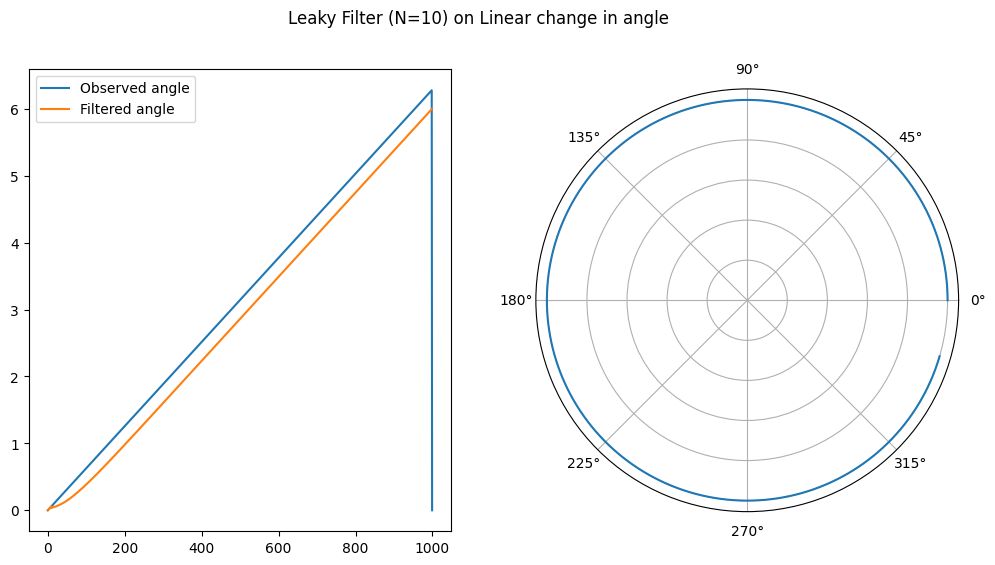

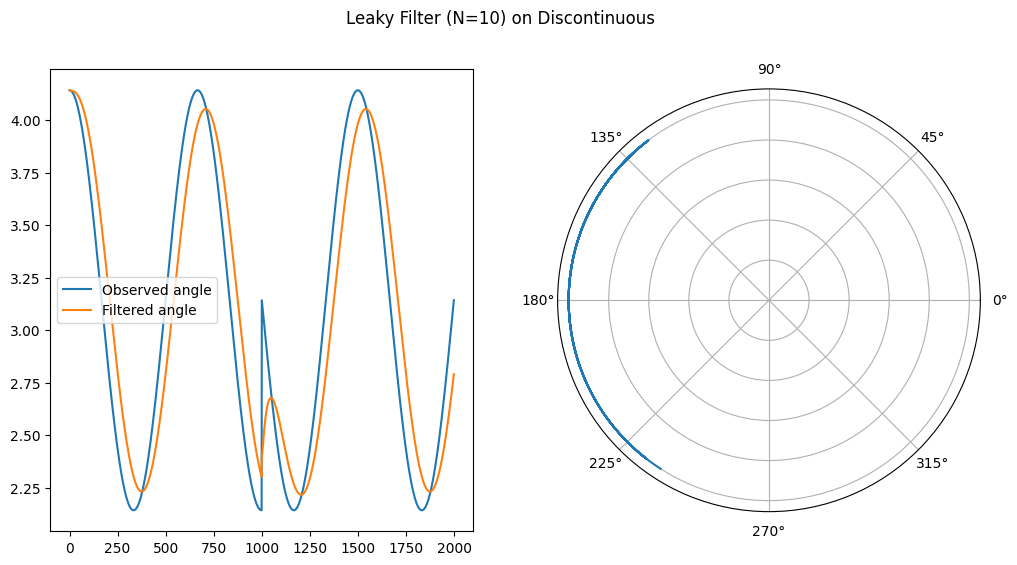

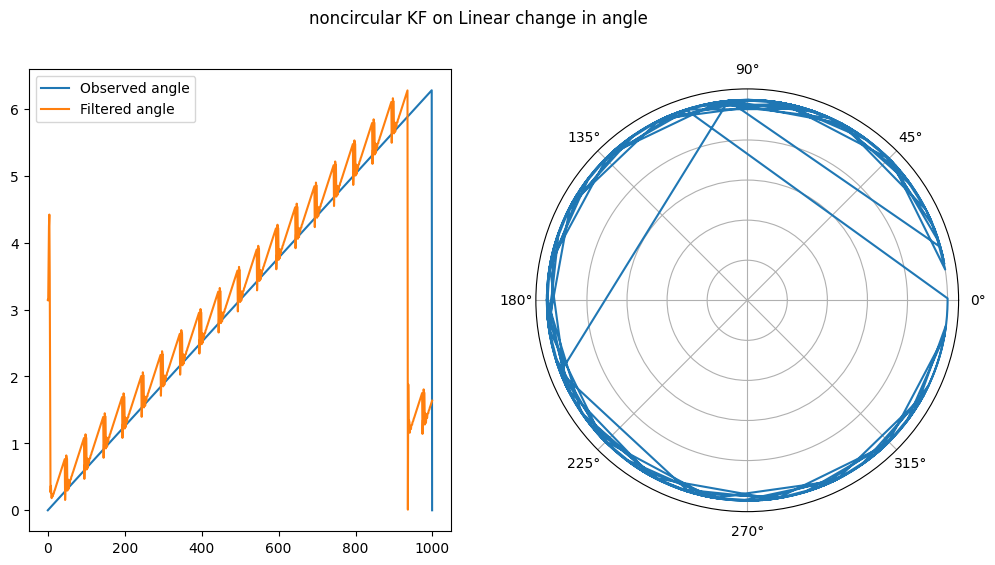

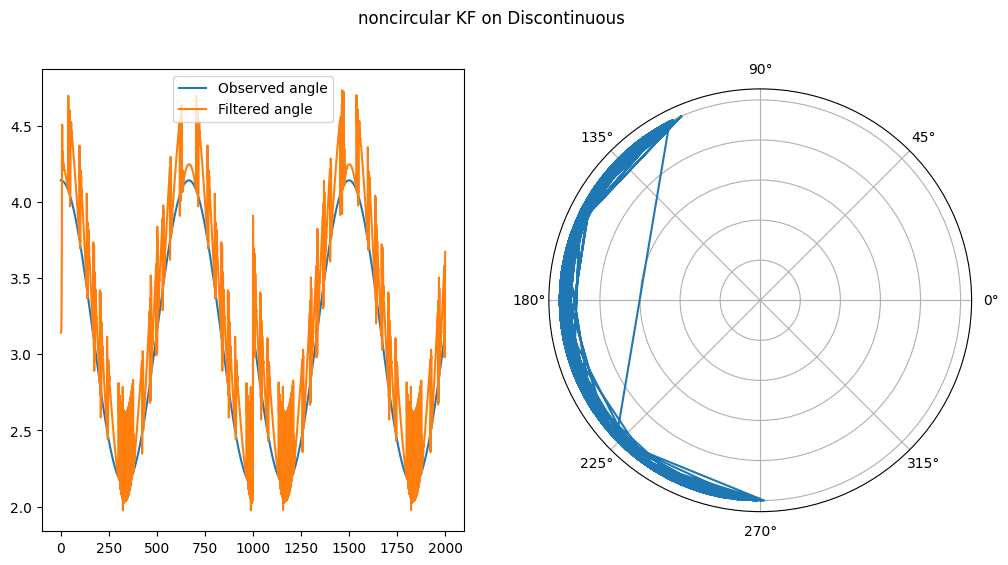

In [278]:
# Plot various datasets with various tests!
filters = [
    LeakyFilter(10),
    KalmanFilter(
        F:= np.array([[1,0,deltat:=0.1],
                    [1,0,0],
                    [deltat**-1, deltat**-1, 0]]),
        Q:= np.eye(3) * 0.001,
        H:= np.vstack([np.ones(num_angles:=1), np.zeros((2,num_angles))]).T,
        R:= np.eye(num_angles) * 0.5,
        u:= np.zeros(3),
        circular:=False
    )
]
datasets: List[AngleTimeseries] = [
    (np.linspace(0, 2*np.pi, 1000), "Linear change in angle"),
    (np.concatenate([np.pi + np.cos(np.linspace(0, 3*np.pi, 1000)), np.pi + np.sin(np.linspace(3*np.pi, 6*np.pi, 1000))]), "Discontinuous")
]

for angle_filter, dataset in product(filters, datasets):
    graph_filter(angle_filter, dataset)